In [1]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt

import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
from SplineEncodingModel.LinearRegressionSpline import EncodingModel

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [130]:
mouse = '4222153.2'
df = pp.load_session_db()


df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging'
df = df[df['Track'].str.contains(tracks,regex=True)]

df_mouse = df[df['MouseName'].str.match(mouse)]
# df_mouse = df_mouse[df_mouse['Track'].str.match('TwoTower_noTimeout') | df_mouse['Track'].str.match('TwoTower_Timeout')]
df_mouse

G:\My Drive\VR_Data\TwoTower\behavior.sqlite


,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1727,4222153.2,08_04_2019,1,TwoTower_foraging,86,1,CA1,2019-04-08,G:\My Drive\VR_Data\TwoTower\4222153.2\08_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\08_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\08_04_2...
1751,4222153.2,10_04_2019,3,TwoTower_foraging,80,1,CA1,2019-04-10,G:\My Drive\VR_Data\TwoTower\4222153.2\10_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\10_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\10_04_2...
1771,4222153.2,12_04_2019,2,TwoTower_foraging,86,1,CA1,2019-04-12,G:\My Drive\VR_Data\TwoTower\4222153.2\12_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\12_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\12_04_2...
1788,4222153.2,14_04_2019,2,TwoTower_foraging,96,1,CA1,2019-04-14,G:\My Drive\VR_Data\TwoTower\4222153.2\14_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\14_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\14_04_2...
1800,4222153.2,15_04_2019,2,TwoTower_foraging,103,1,CA1,2019-04-15,G:\My Drive\VR_Data\TwoTower\4222153.2\15_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\15_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\15_04_2...
1816,4222153.2,16_04_2019,2,TwoTower_foraging,98,1,CA1,2019-04-16,G:\My Drive\VR_Data\TwoTower\4222153.2\16_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\16_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\16_04_2...
1825,4222153.2,17_04_2019,2,TwoTower_foraging,77,1,CA1,2019-04-17,G:\My Drive\VR_Data\TwoTower\4222153.2\17_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\17_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\17_04_2...
1833,4222153.2,18_04_2019,3,TwoTower_foraging,70,1,CA1,2019-04-18,G:\My Drive\VR_Data\TwoTower\4222153.2\18_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\18_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\18_04_2...


In [131]:
sess = df_mouse.iloc[-1]

In [145]:
VRDat,C, S, A = pp.load_scan_sess(sess)

num aberrant ttls 0.0
37344 (37344,) (37344, 21) 121463


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0


In [155]:
C=u.nansmooth(C,[5,0])
C/=C.mean(axis=0).reshape(1,-1)
S/=S.mean(axis=0).reshape(1,-1)
Ssm = sp.ndimage.filters.gaussian_filter1d(S,5,axis=0)

In [134]:
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
effMorph =VRDat.morph._values+VRDat.bckgndJitter._values + VRDat.wallJitter._values
effMorph = (effMorph-np.amin(effMorph))/(np.amax(effMorph)-np.amin(effMorph)+.01)+.001

In [156]:
posmask = (VRDat.pos>0) & (VRDat.pos<450)

C_model = C[posmask,:]
S_model=Ssm[posmask,:]
pos_model = VRDat.pos._values[posmask]
effMorph_model = effMorph[posmask]



trainmask = np.zeros(C_model.shape[0])
# inds = np.random.permutation(C_model.shape[0])[:int(.7*C_model.shape[0])]
# trainmask[inds] +=1
trainmask[:int(.9*C_model.shape[0])]+=1
trainmask = trainmask>0


In [157]:

splmdl = EncodingModel(ops={'n_ctrl_pts_morph':2,'n_ctrl_pts_pos':3})
X_train = splmdl.make_design_matrix(pos_model[trainmask],effMorph_model[trainmask])
X_test = splmdl.make_design_matrix(pos_model[~trainmask],effMorph_model[~trainmask])

(5,)


In [158]:
splmdl.fit_linear(X_train,C_model[trainmask,:])

In [159]:
Y= splmdl.predict_linear(X_test)

In [160]:
print(Y.shape)

(3170, 1951)


In [161]:
S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10,speed=VRDat.speed._values)
S_trial_mat[np.isnan(S_trial_mat)]=0
S_trial_mat = sp.ndimage.filters.gaussian_filter1d(S_trial_mat,1,axis=1)

tmp = trial_info['morphs'] +  trial_info['wallJitter'] + trial_info['bckgndJitter']
pm_rm = u.morph_pos_rate_map(S_trial_mat,tmp)
msort = np.argsort(tmp)

C:\Users\mplitt\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consum

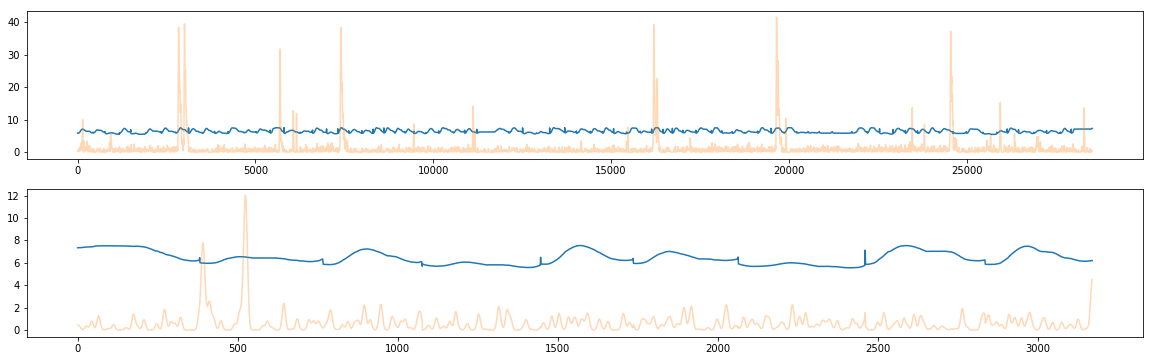

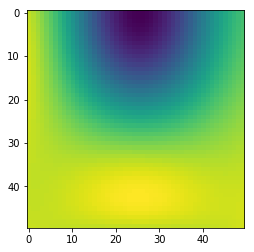

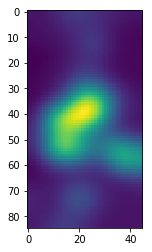

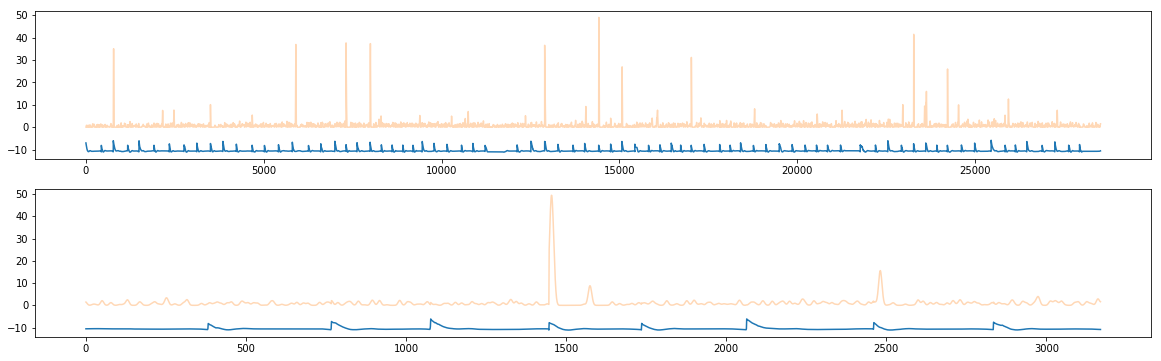

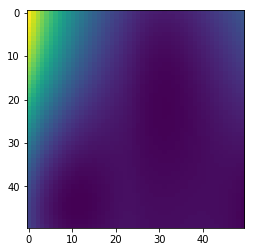

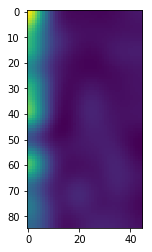

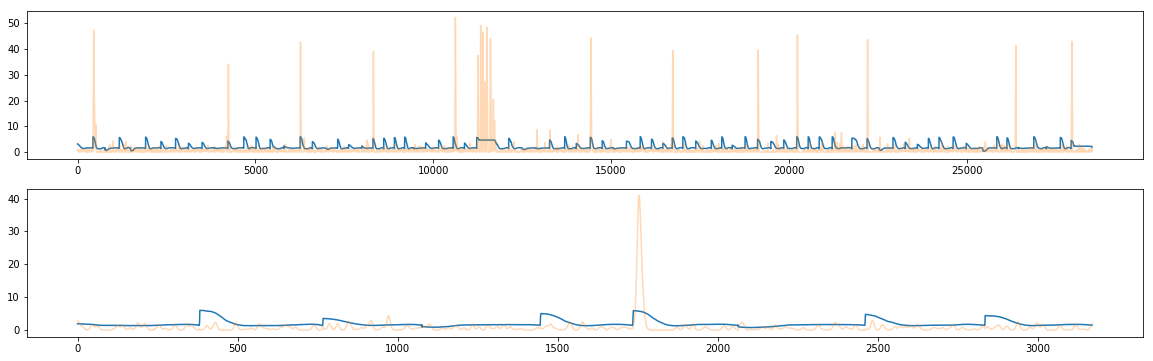

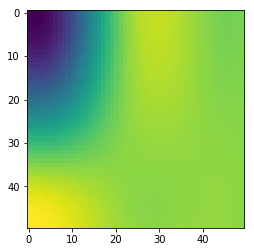

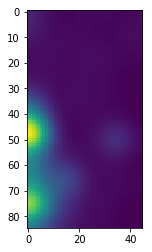

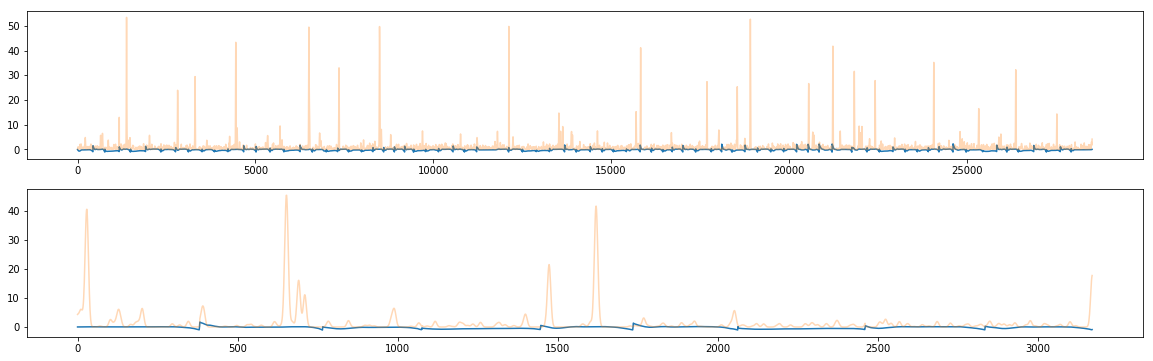

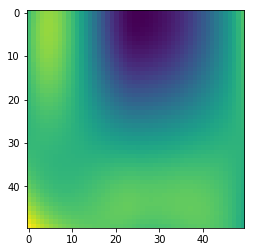

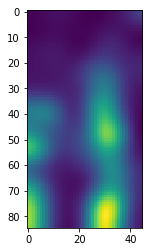

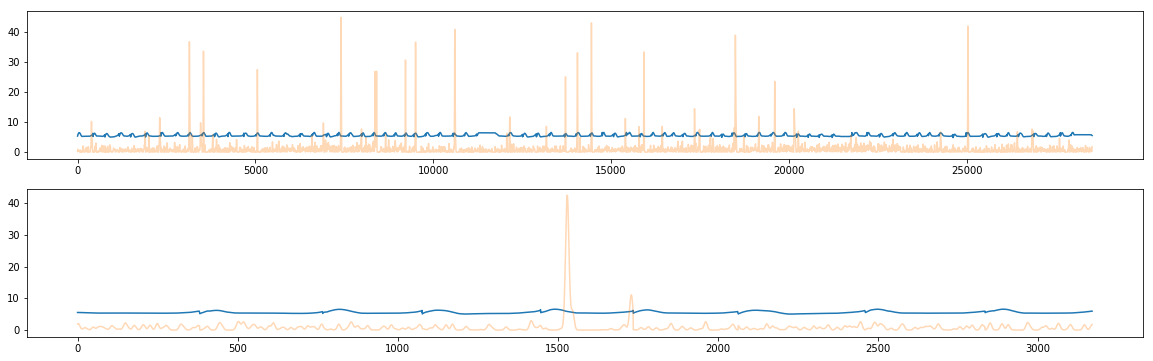

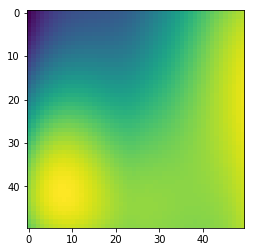

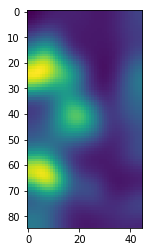

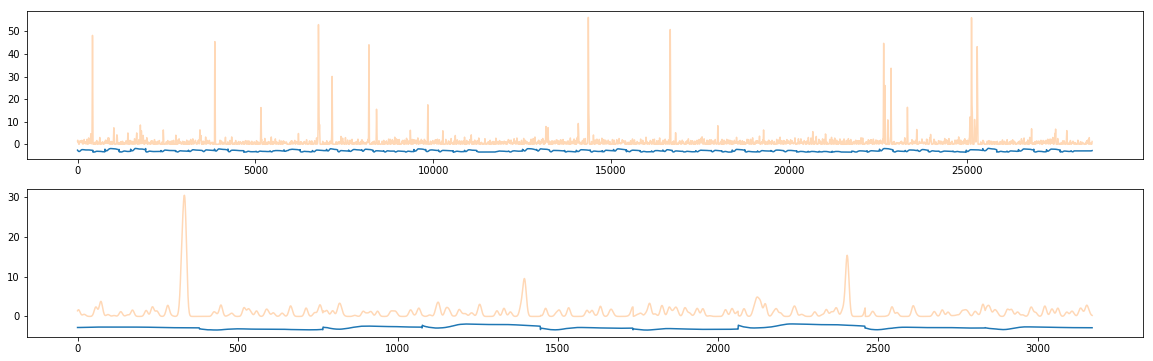

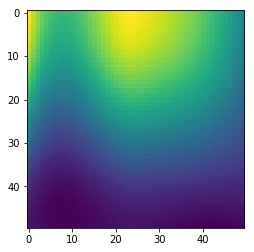

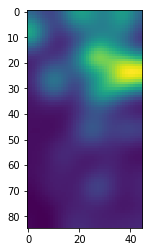

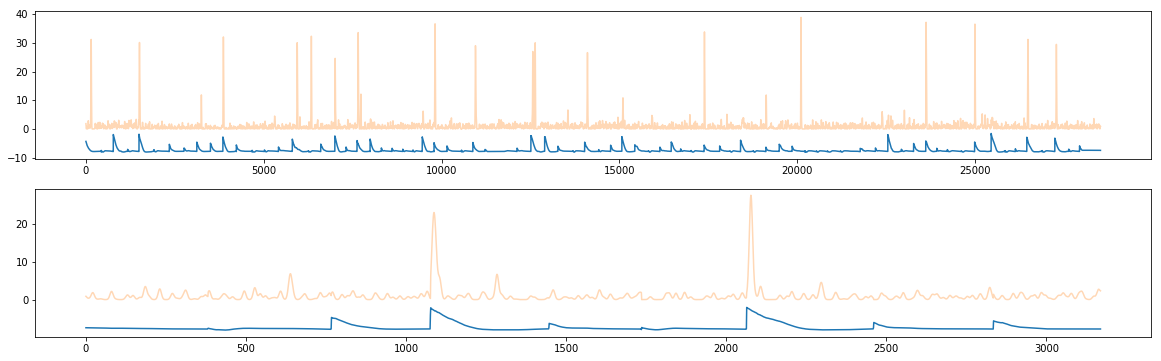

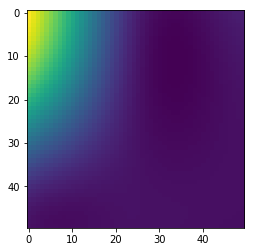

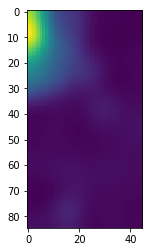

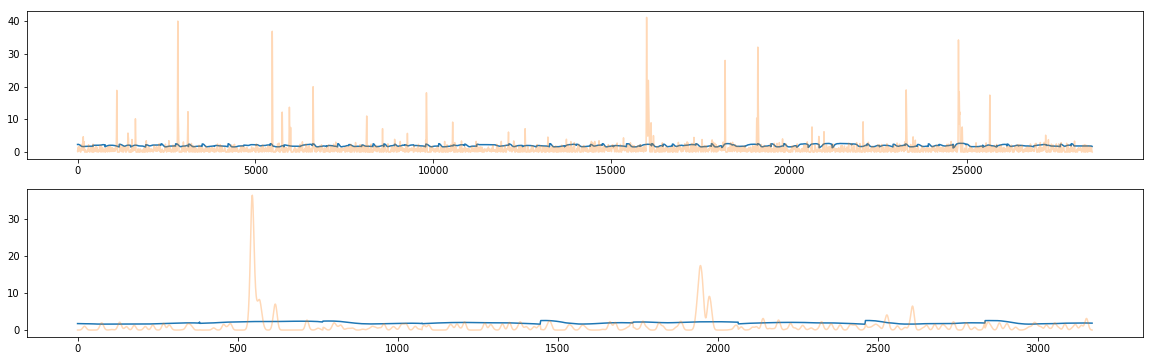

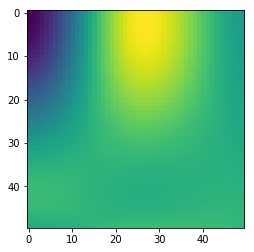

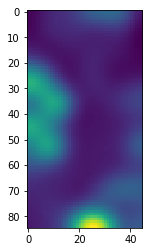

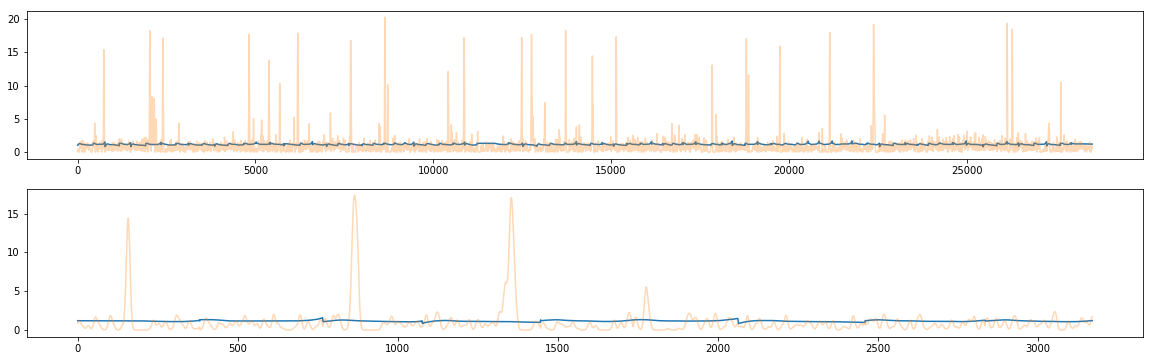

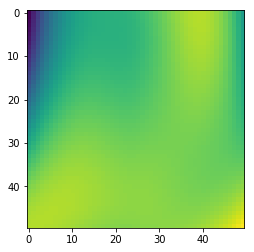

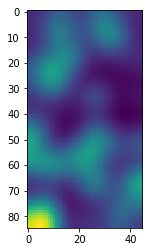

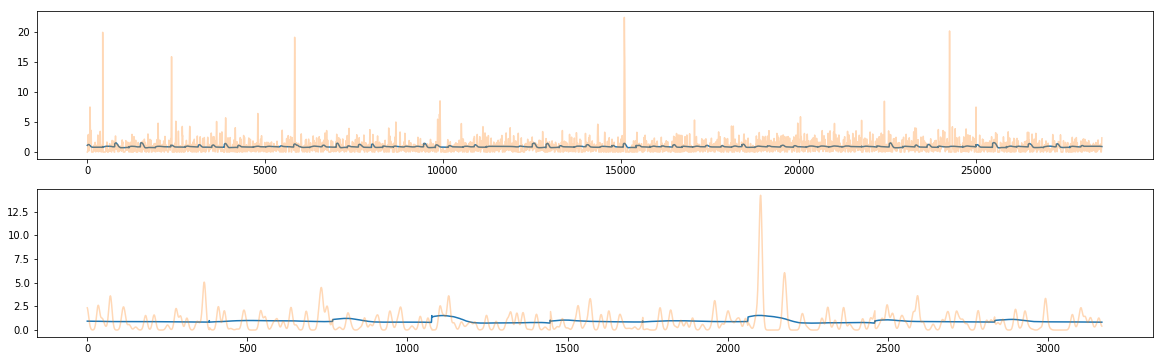

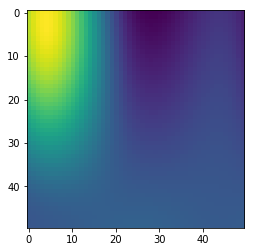

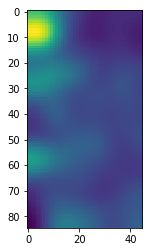

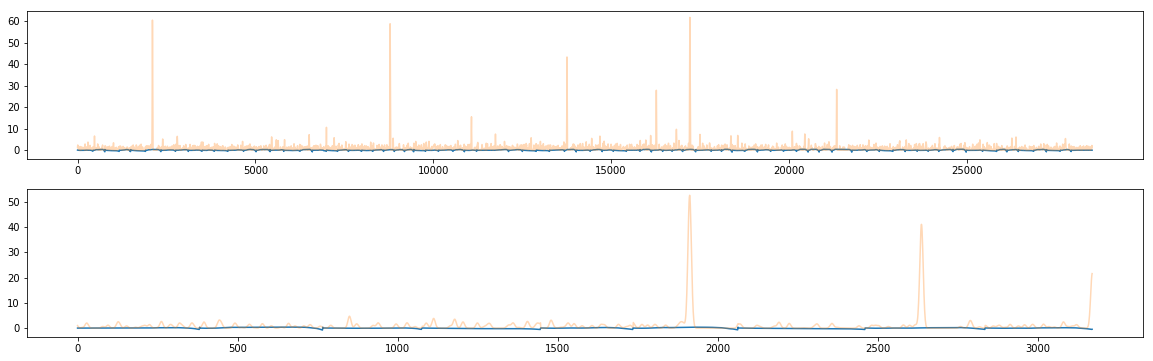

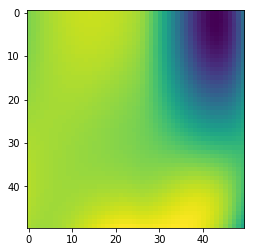

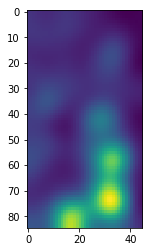

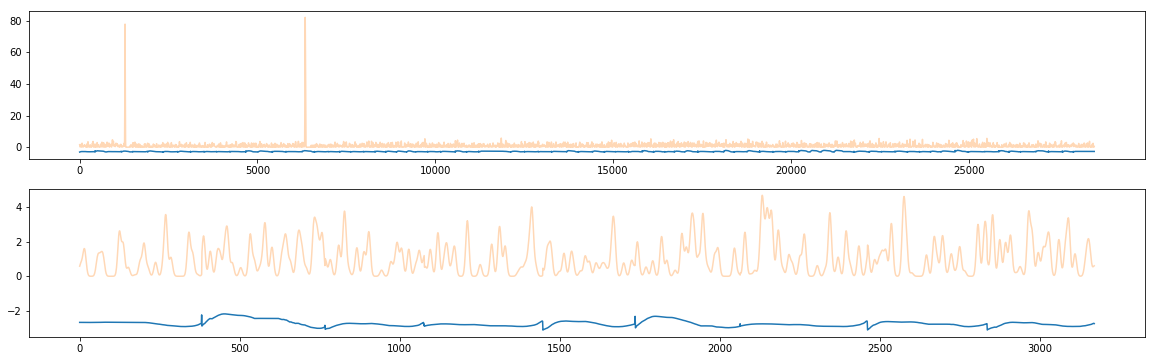

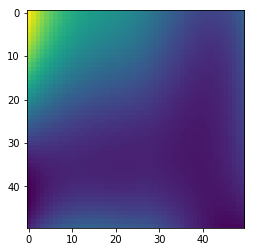

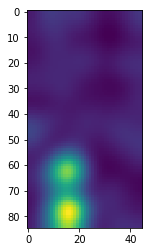

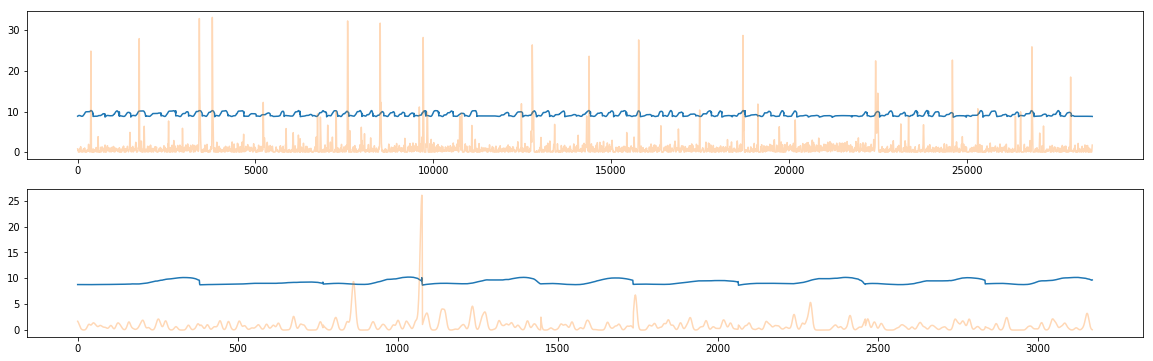

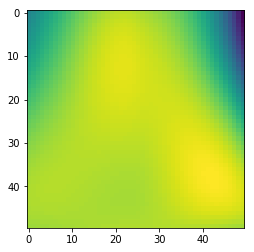

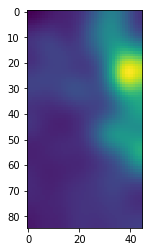

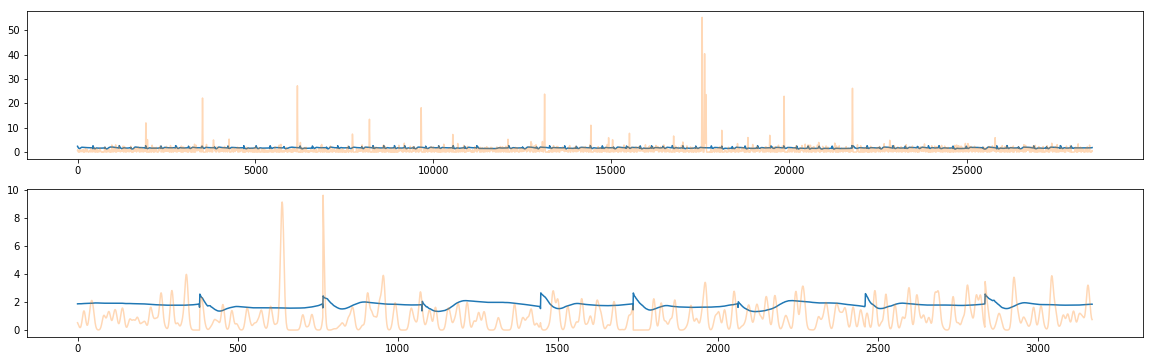

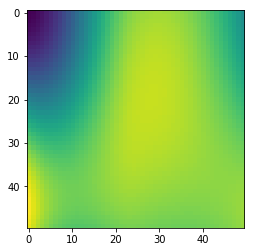

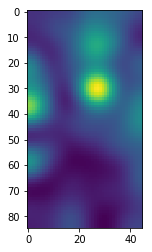

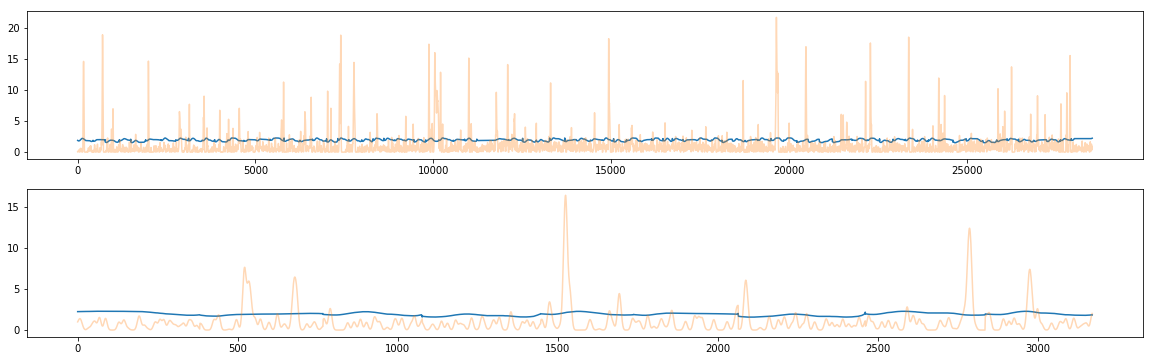

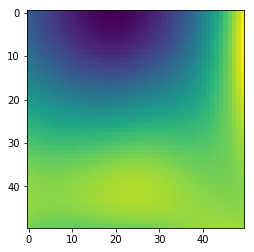

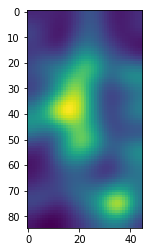

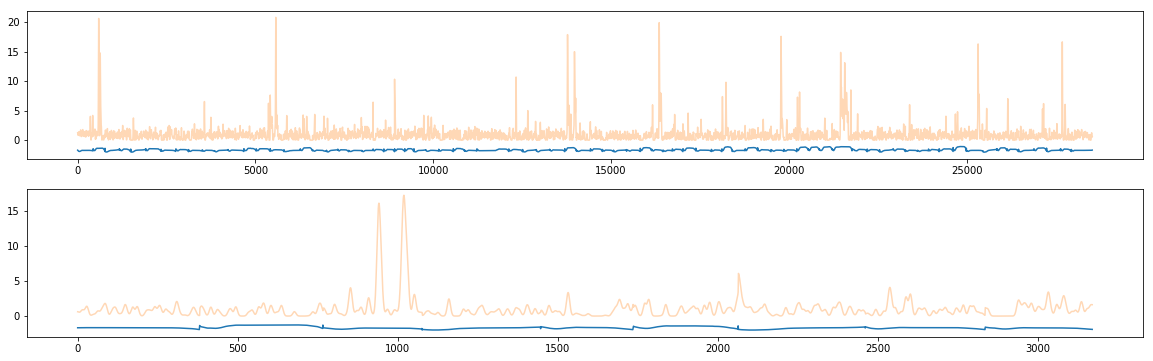

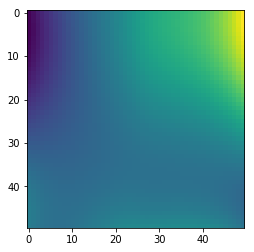

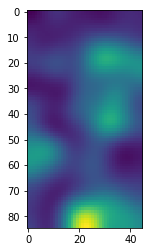

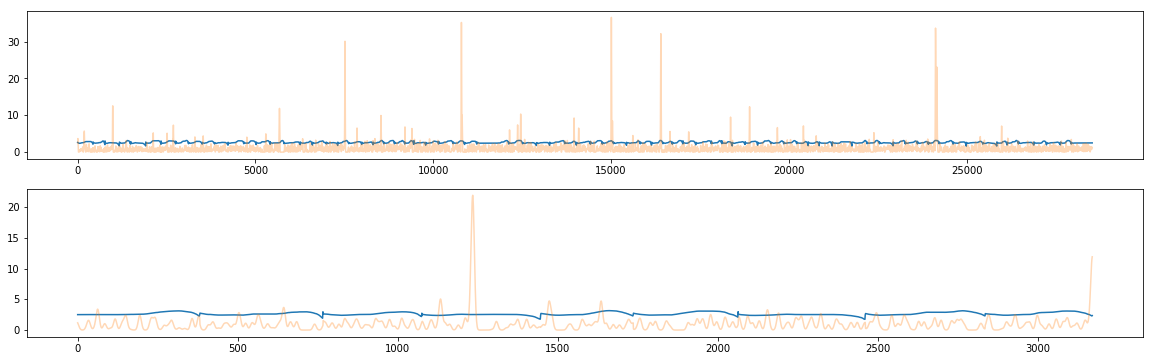

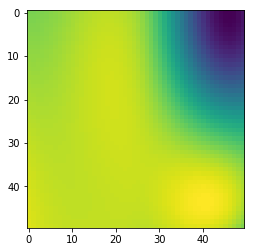

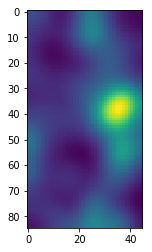

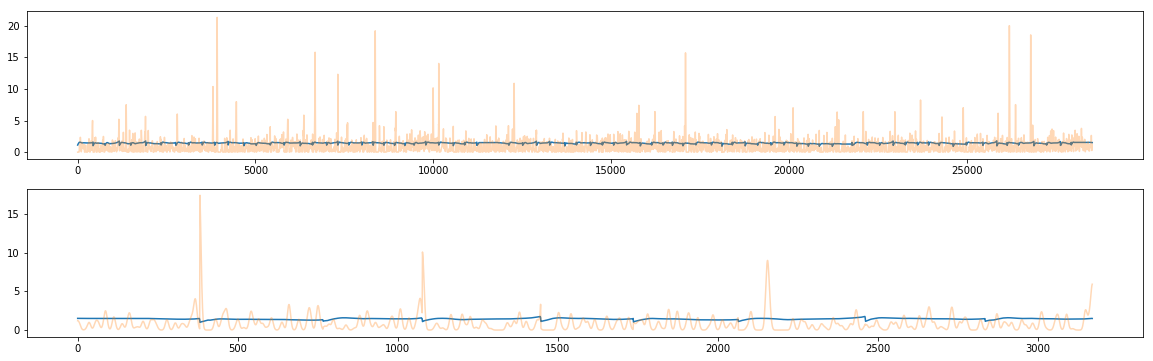

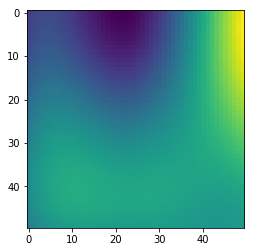

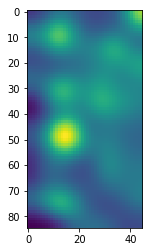

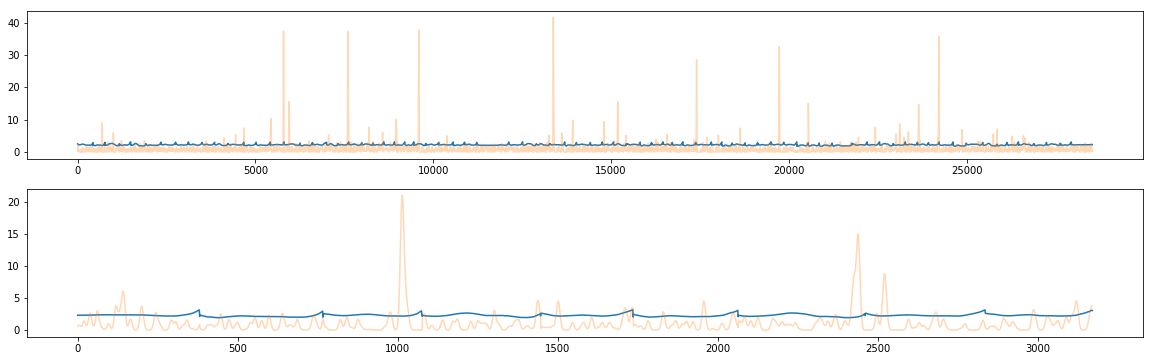

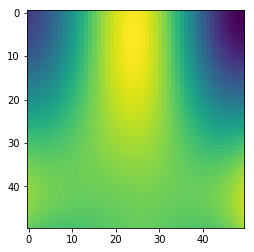

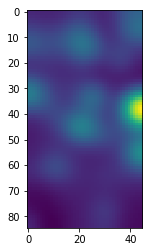

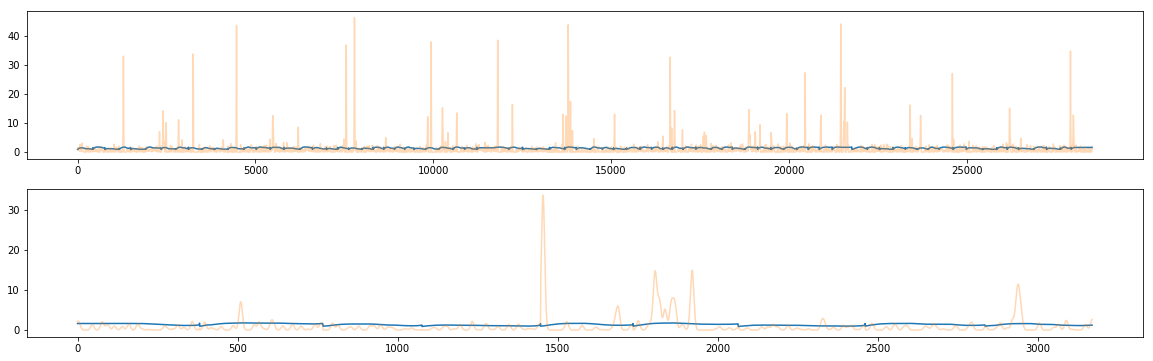

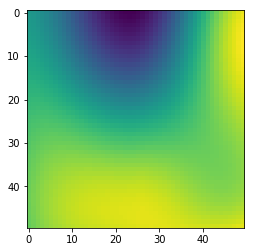

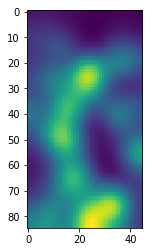

In [165]:

for cell in range(1,C.shape[1],100):
    f,ax = plt.subplots(2,1,figsize=[20,6])
    splmdl.fit_linear(X_train,S_model[trainmask,cell])
    Y_train= splmdl.predict_linear(X_train)
    Y_test = splmdl.predict_linear(X_test)
    ax[0].plot(Y_train,alpha=1)
    ax[0].plot(S_model[trainmask,cell],alpha=.3)
    
    ax[1].plot(Y_test,alpha=1)
    ax[1].plot(S_model[~trainmask,cell],alpha=.3)
    
    
    
    posmat = np.linspace(0.01,449.9).reshape([1,-1])*np.ones([50,1])
    morphmat = np.linspace(0.01,.99).reshape([-1,1])*np.ones([1,50])
    Xplot= splmdl.make_design_matrix(posmat.reshape([-1,]),morphmat.reshape([-1,]))
#     print(posmat.reshape([-1,]),morphmat.reshape([-1,]))
    filt = splmdl.predict_linear(Xplot).reshape([50,50])
    f,ax = plt.subplots()
#     #ax.plot(filt)
    ax.imshow(filt)
# #     f,ax = plt.subplots()
# #     ax.imshow()
    
    f,ax = plt.subplots()
    ax.imshow(sp.ndimage.filters.gaussian_filter(S_trial_mat[msort,:,cell],[5,5]),aspect='equal') #vmax=np.percentile(S_trial_mat[msort,:,cell],90)
    

In [112]:
cell=60
splmdl.fit_poisson(X,S[posmask,cell],alpha=0)

Optimization terminated successfully.
         Current function value: 19931.004897
         Iterations: 35
         Function evaluations: 64
         Gradient evaluations: 98
         Hessian evaluations: 35


(4,)
Optimization terminated successfully.
         Current function value: -1417327.270079
         Iterations: 71
         Function evaluations: 214
         Gradient evaluations: 284
         Hessian evaluations: 71
(3825, 21)
(4,)


C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


Optimization terminated successfully.
         Current function value: -1689383.589661
         Iterations: 28
         Function evaluations: 58
         Gradient evaluations: 85
         Hessian evaluations: 28
(3825, 21)
(4,)
Optimization terminated successfully.
         Current function value: -1087919.637664
         Iterations: 31
         Function evaluations: 63
         Gradient evaluations: 93
         Hessian evaluations: 31
(3825, 21)
(4,)
Optimization terminated successfully.
         Current function value: -1407944.862978
         Iterations: 55
         Function evaluations: 150
         Gradient evaluations: 204
         Hessian evaluations: 55
(3825, 21)
(4,)
Optimization terminated successfully.
         Current function value: -2245340.758201
         Iterations: 35
         Function evaluations: 75
         Gradient evaluations: 109
         Hessian evaluations: 35
(3825, 21)
(4,)
Optimization terminated successfully.
         Current function value: -1570304.19714

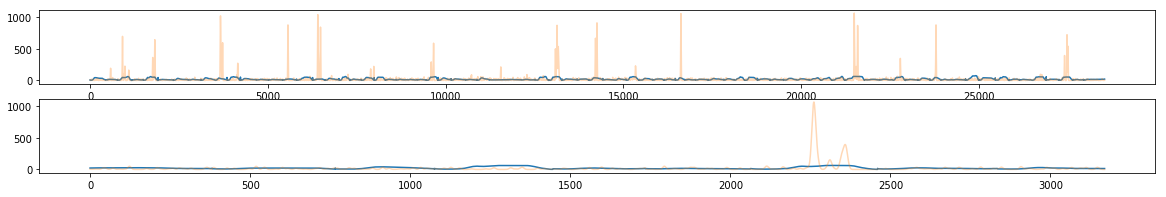

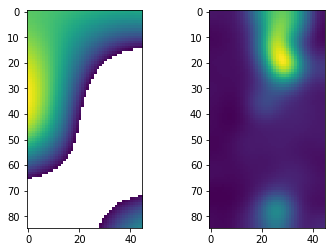

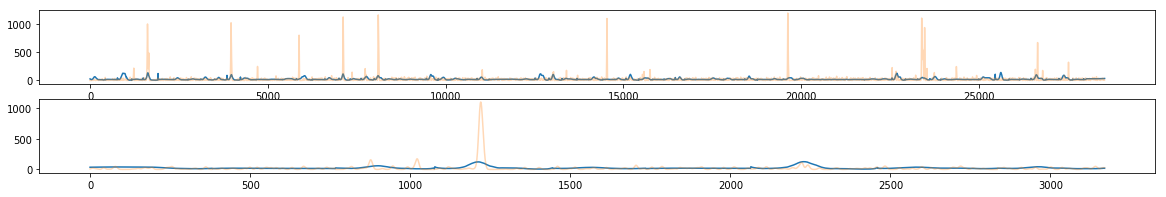

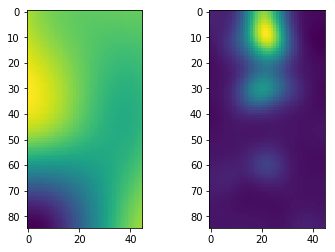

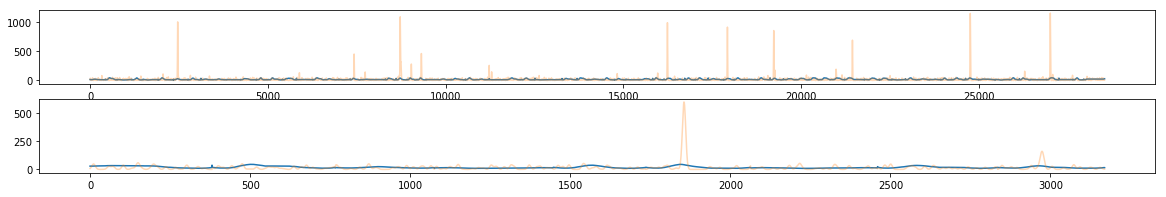

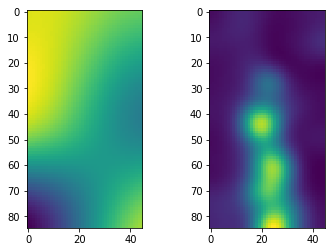

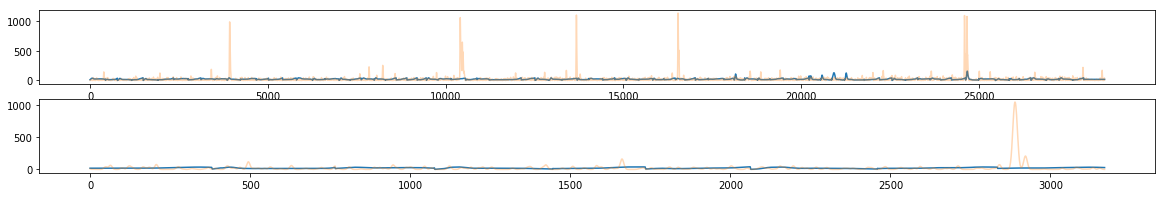

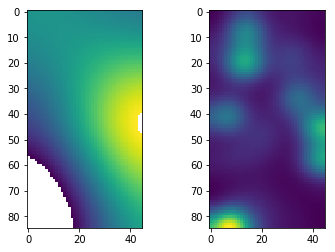

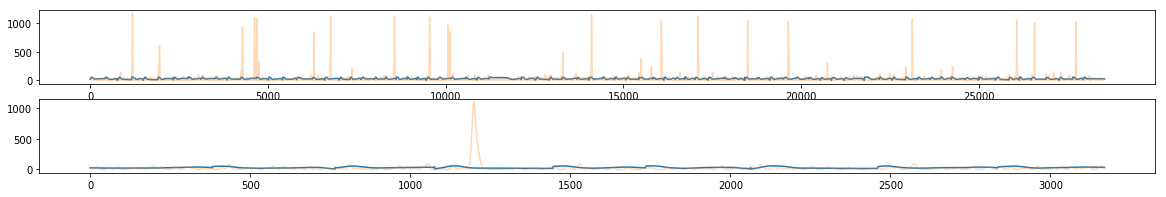

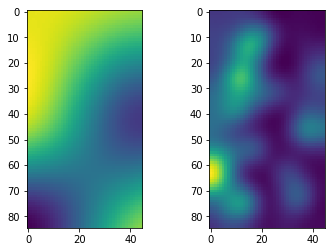

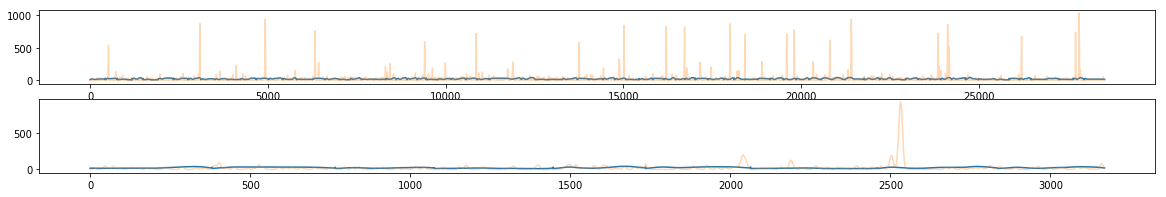

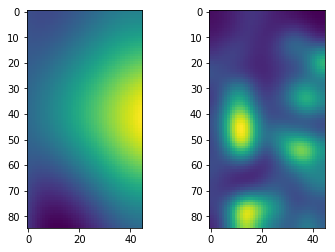

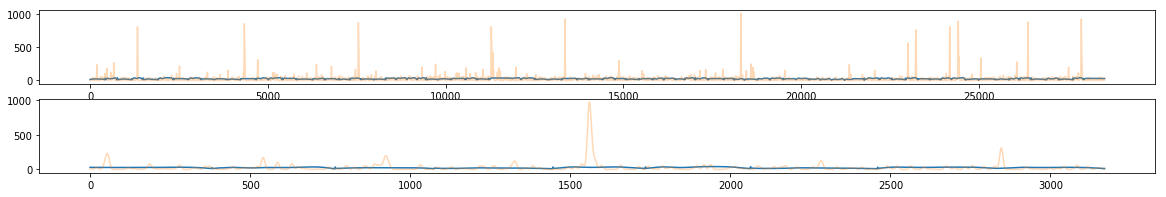

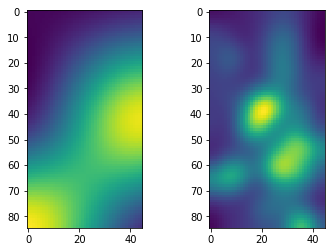

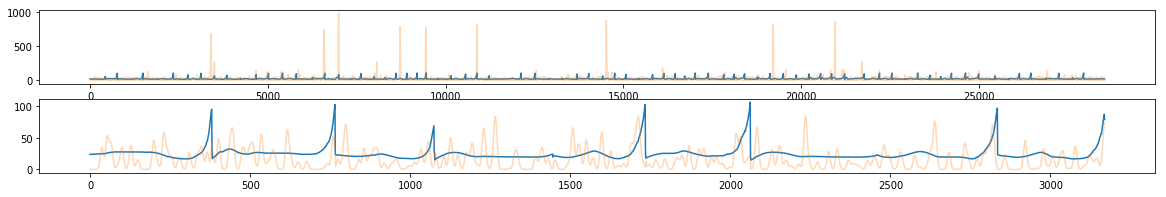

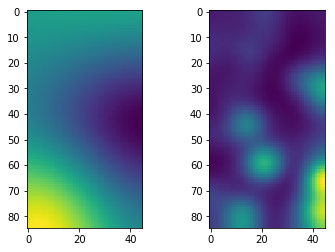

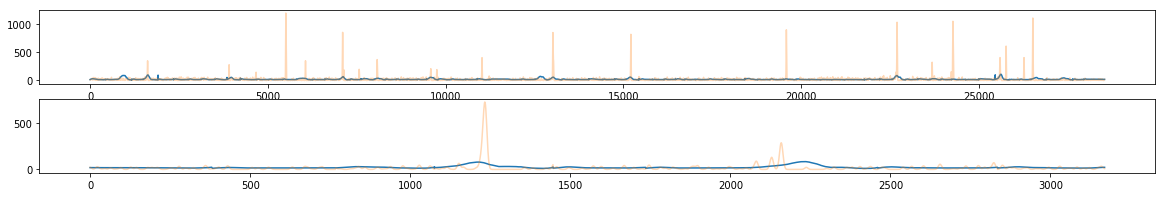

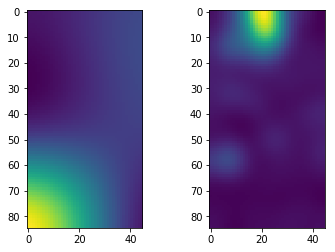

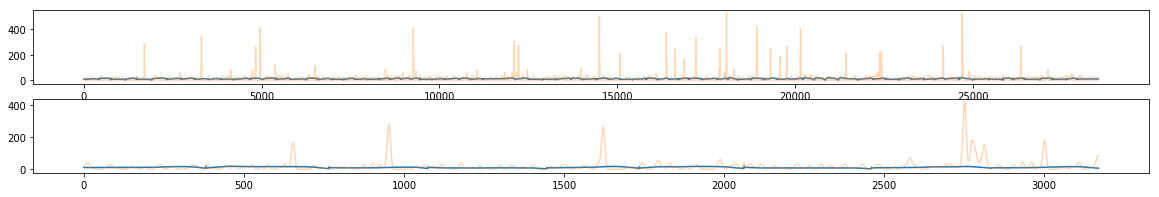

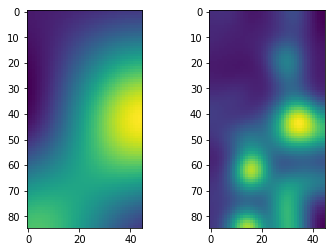

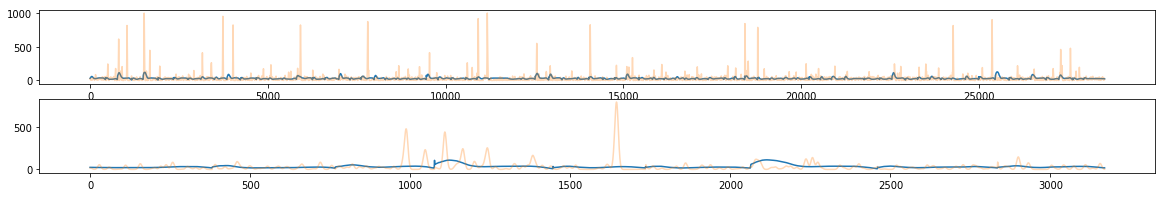

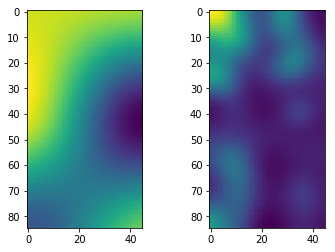

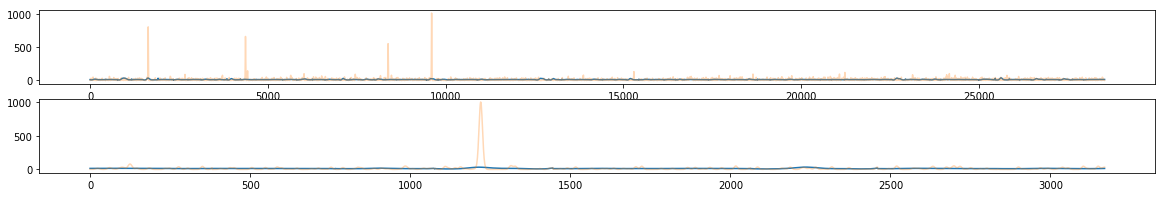

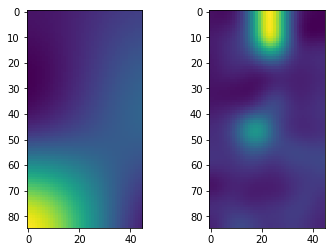

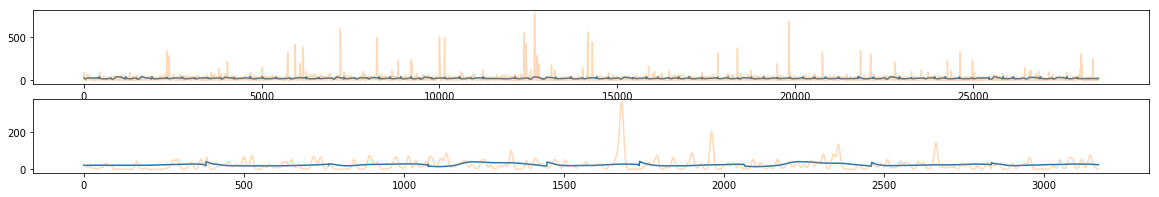

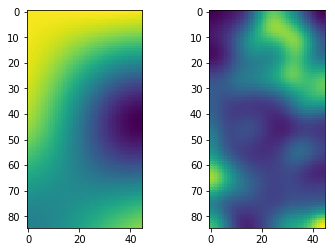

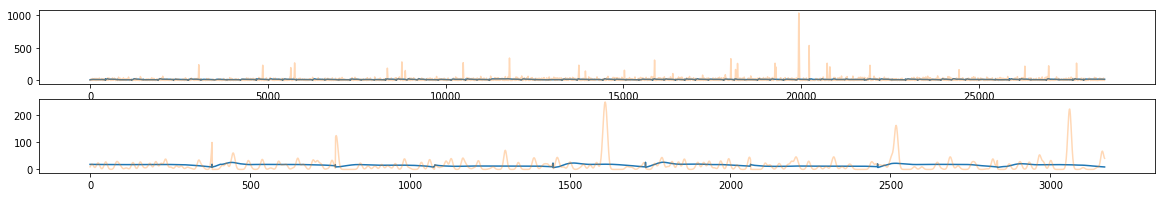

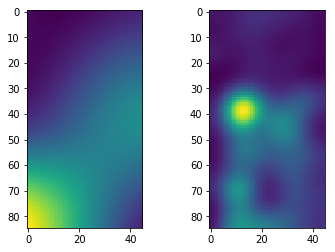

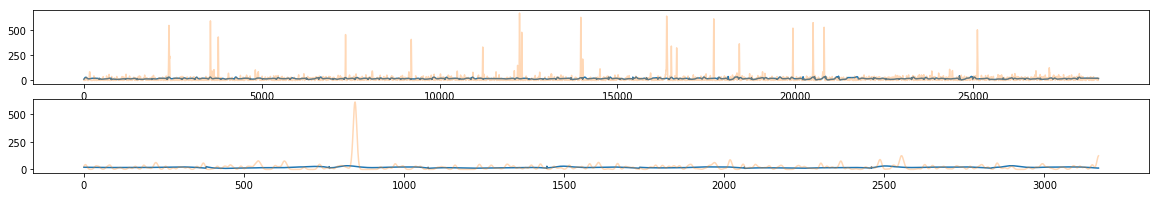

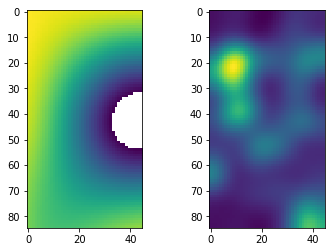

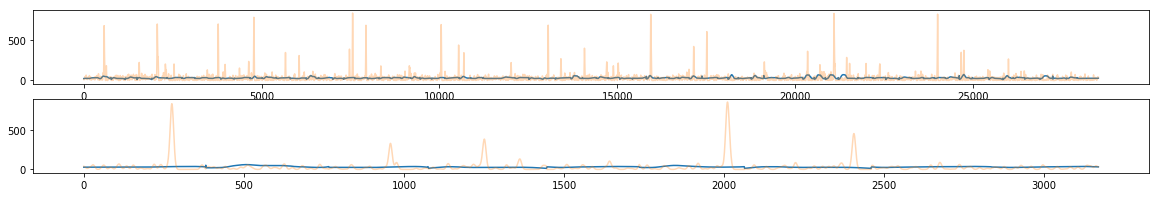

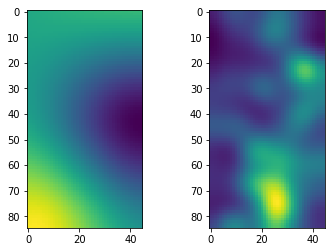

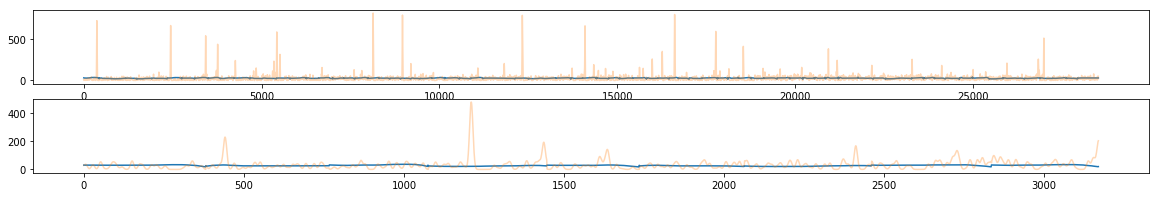

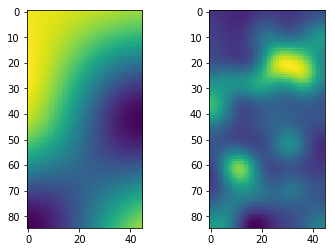

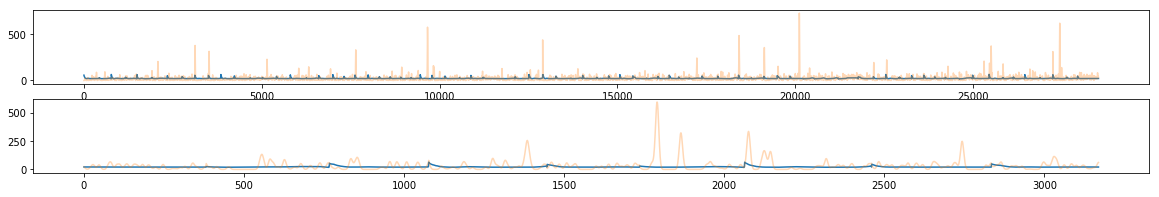

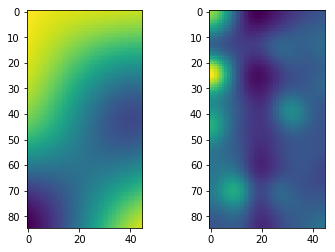

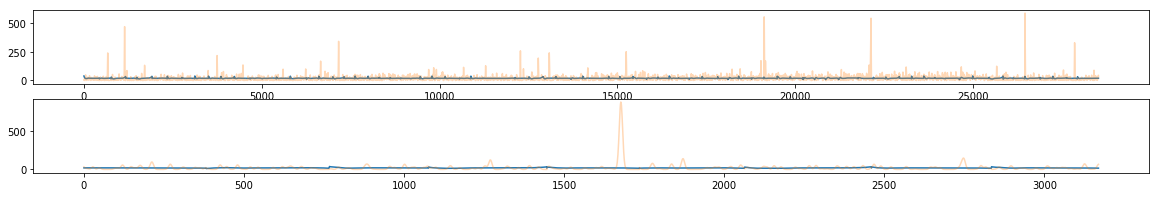

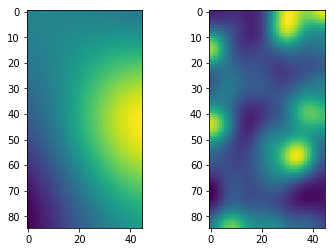

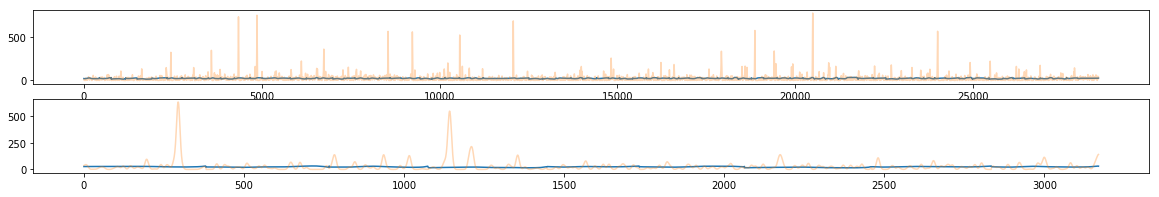

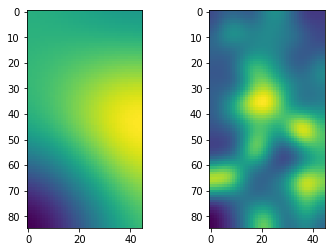

In [151]:
splmdl= None
for cell in range(0,S.shape[1],100):
    splmdl = EncodingModel(ops={'n_ctrl_pts_pos':2,'n_ctrl_pts_morph':3})
#     X_train = splmdl.make_design_matrix(,effMorph[posmask])
    splmdl.fit_poisson(X_train,S_model[trainmask,cell],alpha=0)
    Y_train = splmdl.predict_poisson(X_train)
    Y_test = splmdl.predict_poisson(X_test)
    f,ax = plt.subplots(2,1, figsize=[20,3])
    
    ax[0].plot(Y_train,alpha=1)
    ax[0].plot(S_model[trainmask,cell],alpha=.3)
    
    ax[1].plot(Y_test,alpha=1)
    ax[1].plot(S_model[~trainmask,cell],alpha=.3)
    
    posmat = np.linspace(0.01,449.9,num=S_trial_mat.shape[1]).reshape([1,-1])*np.ones([S_trial_mat.shape[0],1])
    morphmat = np.linspace(0.01,.99,num=S_trial_mat.shape[0]).reshape([-1,1])*np.ones([1,S_trial_mat.shape[1]])

    Xplot= splmdl.make_design_matrix(posmat.reshape([-1,]),morphmat.reshape([-1,]))
    print(Xplot.shape)
    filt = splmdl.predict_poisson(Xplot).reshape(S_trial_mat.shape[:-1])
    f,ax = plt.subplots(1,2)
    ax[0].imshow(np.log(filt))#,vmax=np.percentile(filt.ravel(),80))
    ax[1].imshow(sp.ndimage.filters.gaussian_filter(S_trial_mat[msort,:,cell],[5,5])) #,vmax=np.percentile(S_trial_mat[:,:,cell],80))

In [116]:
posmat = np.linspace(0.01,449.9).reshape([1,-1])*np.ones([50,1])
morphmat = np.linspace(0.01,.99).reshape([-1,1])*np.ones([1,50])
Xplot= splmdl.make_design_matrix(posmat.reshape([-1,]),morphmat.reshape([-1,]))

In [117]:
filt = splmdl.predict_poisson(Xplot).reshape([50,50])

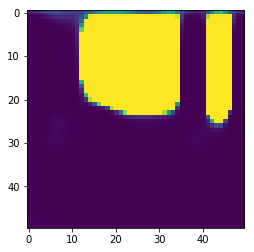

In [138]:
f,ax = plt.subplots()
ax.imshow(filt,vmax=np.percentile(filt.ravel(),75))

In [121]:
print(filt)

[[339.33922904 373.94456949 456.15500975 ... 739.64652189 492.07553716
  416.02510193]
 [ 27.52168842  30.88191299  49.45184061 ... 489.77205976  70.37725417
   27.62879148]
 [  1.07619032   1.23346545   2.79781956 ... 290.98725385   5.74984645
    0.8307915 ]
 ...
 [ 19.64462045  29.3802172   28.77297193 ...   9.91804812  10.35368861
   11.30625225]
 [ 28.75496044  35.1581104   29.43253712 ...   9.00736361  10.43122829
   15.57072707]
 [ 45.52244402  43.74286878  29.7267194  ...   8.15372099  10.41181779
   20.73092916]]
